# PV Power Forecasting

In [2]:
import pandas as pd
import numpy as np
from astral.sun import sun, zenith
from astral import LocationInfo
import datetime
import os
import warnings
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor

from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_mean_width_score, regression_coverage_score


random_state = 77

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

In [5]:
# source: https://openei.org/wiki/PVDAQ/Sites/Farm_Solar_Array

In [3]:
modelFolder = "Models"
if not os.path.exists(modelFolder):
    os.makedirs(modelFolder)

In [4]:
evalFolder = "EnergyHubEval"
if not os.path.exists(evalFolder):
    os.makedirs(evalFolder)

## Data exploration

In [6]:
yearTest = 2021 
maxRefPowerkW = 71

### PV Power

**PV plant specifications**:

- "System": {
    "system_id": 2107,
    "public_name": "Farm Solar Array",
    "power(kW DC)": 893.0,
    "started_on": "2017-01-01 00:00:00",
    "comments": "Actual timezone is US/Pacific but needed to use special PST8PDT. System is a participant in the DOE Solar Data Prize 2023",
    "data_prize": "t",
    "timezone_code": "PST8PDT",
    "us_region": "West",
    "agripv" : "f",
    "first_timestamp": "2018-12-15 00:15:00",
    "last_timestamp" : "2023-11-15 12:21:50",
    "years_of_data" : 4.9205,
    "data_time_resolution" : "5-15 min",
    "number_data_channels" : 125,
    "data_size" : "445 MB"
    },

- "Site": {
    "site_id": 7211,
    "public_name": "FSA_1",
    "location": "Arbuckle, CA",
    "us_region": "West",
    "latitude": 38.996306,
    "longitude": -122.134111,
    "elevation(m)": 10.0,
    "climate_type": "Csa"
    },


In [7]:
power = pd.read_csv('Data/PVDAQ_2107_CA_US/2107_meter_15m_data.csv')
power.columns = ['dt', 'powerkW']

In [8]:
power.loc[:, 'datetime'] = pd.to_datetime(power['dt'], utc=False).dt.tz_localize('PST8PDT', ambiguous=False)
power.loc[:, 'date'] = power['datetime'].dt.date
power.drop(columns=['dt'], inplace=True)
power.dropna(inplace=True)

In [9]:
power[~power.isnull()].describe()

,powerkW
count,240062.000000
mean,153.091341
std,222.516322
min,0.000000
25%,0.000000
50%,0.000000
75%,302.720000
max,1783.680000


In [10]:
location = LocationInfo("Arbuckle", "America", "America/Los_Angeles", 38.996306, -122.134111)

sunInfo = pd.DataFrame({'date': pd.Series(dtype='object'), 
                        'sunrise': pd.Series(dtype='datetime64[ns, UTC]'), 
                        'sunset': pd.Series(dtype='datetime64[ns, UTC]')})

for date in power['date'].unique():
    s = sun(location.observer, date=date, tzinfo=location.timezone)
    sunInfo = pd.concat([sunInfo, pd.DataFrame({'date': [date], 'sunrise': [s['sunrise']], 'sunset': [s['sunset']]})], ignore_index=True)

power.drop(columns=['date'], inplace=True)

In [ ]:
sunInfo['sunrise'] = pd.to_datetime(sunInfo['sunrise'])
sunInfo['sunset'] = pd.to_datetime(sunInfo['sunset'])
sunInfo.loc[:, 'solarNoon'] = (sunInfo['sunrise'] + (sunInfo['sunset'] - sunInfo['sunrise']) / 2).dt.time

In [12]:
sunInfo.sort_values(by='solarNoon')
# sunInfo.head()

,date,sunrise,sunset,solarNoon
1401,2020-11-02,2020-11-02 06:37:54.982404-08:00,2020-11-02 17:05:42.254776-08:00,11:51:48.618590
1036,2019-11-03,2019-11-03 06:38:10.977645-08:00,2019-11-03 17:05:26.567835-08:00,11:51:48.772740
1400,2020-11-01,2020-11-01 06:36:49.137309-08:00,2020-11-01 17:06:48.632216-08:00,11:51:48.884762
1402,2020-11-03,2020-11-03 06:39:01.045271-08:00,2020-11-03 17:04:37.326985-08:00,11:51:49.186128
1037,2019-11-04,2019-11-04 06:39:17.090928-08:00,2019-11-04 17:04:22.001062-08:00,11:51:49.545995
...,...,...,...,...
799,2019-03-11,2019-03-11 07:26:25.920923-07:00,2019-03-11 19:11:12.402146-07:00,13:18:49.161534
1164,2020-03-10,2020-03-10 07:26:48.287506-07:00,2020-03-10 19:10:57.574600-07:00,13:18:52.931053
798,2019-03-10,2019-03-10 07:27:58.032311-07:00,2019-03-10 19:10:11.586953-07:00,13:19:04.809632
1163,2020-03-09,2020-03-09 07:28:20.304395-07:00,2020-03-09 19:09:56.698412-07:00,13:19:08.501403


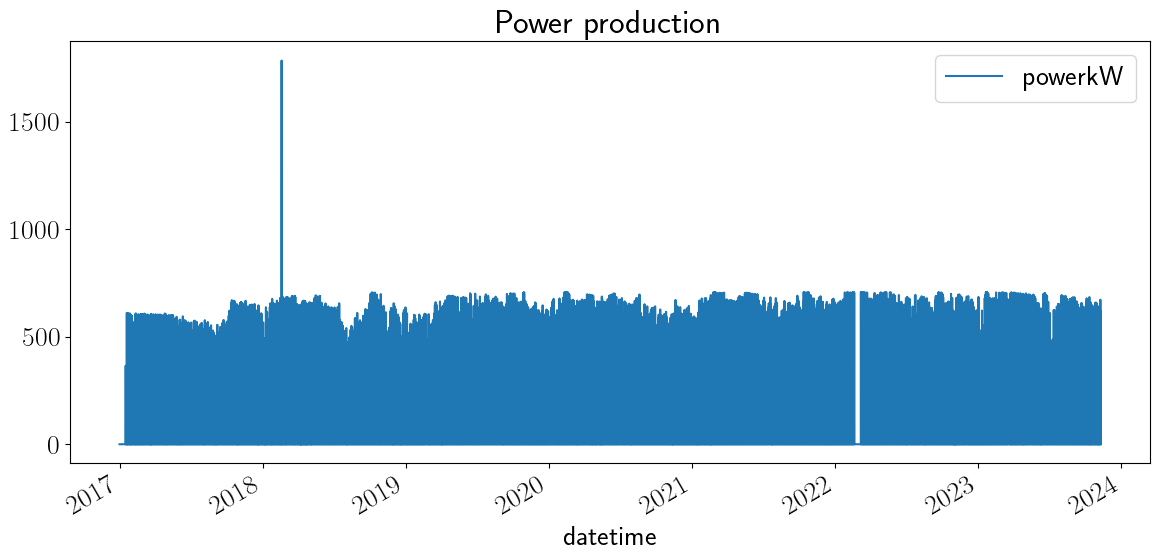

In [13]:
# power[power['datetime'].dt.year==2018].plot(x='datetime', y='powerkW', title='Power production', figsize=(20, 6))
power.plot(x='datetime', y='powerkW', title='Power production', figsize=(12, 6))
plt.tight_layout()

In [14]:
# remove low power from all training years
power['date'] = power['datetime'].dt.date
dailyAggPower = power[power['datetime'].dt.year>=2018].groupby('date').sum('powerkW').copy()
datesOutliersLowPower = dailyAggPower[(dailyAggPower['powerkW']<=30)].index 
datesOutliersLowPower = datesOutliersLowPower[~datesOutliersLowPower.astype(str).str.contains(str(yearTest)+'-')]
datesOutliersLowPower

Index([2019-02-22, 2019-02-23, 2020-01-09, 2020-01-18, 2022-02-19, 2022-02-20,
       2022-02-21, 2022-02-22, 2022-02-23, 2022-02-24, 2022-02-25, 2022-02-26,
       2022-02-27, 2022-02-28, 2022-03-01, 2022-03-02, 2022-03-03, 2022-03-04,
       2022-03-05, 2022-03-06, 2022-12-03, 2023-03-18, 2023-03-19],
      dtype='object', name='date')

In [15]:
power.sort_values(by='powerkW', ascending=False).head(10)

,powerkW,datetime,date
39693,1783.68,2018-02-18 12:30:00-08:00,2018-02-18
178107,708.48,2022-02-01 12:00:00-08:00,2022-02-01
178104,708.48,2022-02-01 11:15:00-08:00,2022-02-01
178108,707.84,2022-02-01 12:15:00-08:00,2022-02-01
212180,707.84,2023-01-22 12:15:00-08:00,2023-01-22
178105,707.84,2022-02-01 11:30:00-08:00,2022-02-01
187318,707.84,2022-05-08 11:45:00-07:00,2022-05-08
212181,707.84,2023-01-22 12:30:00-08:00,2023-01-22
212179,707.84,2023-01-22 12:00:00-08:00,2023-01-22
178106,707.84,2022-02-01 11:45:00-08:00,2022-02-01


In [16]:
maxDataPowerkW = 710 

In [17]:
datesOurliersHighPower = power.sort_values(by='powerkW', ascending=False).head(1)['date']
datesOurliersHighPower

39693    2018-02-18
Name: date, dtype: object

<Axes: title={'center': 'Daily power production'}, xlabel='date'>

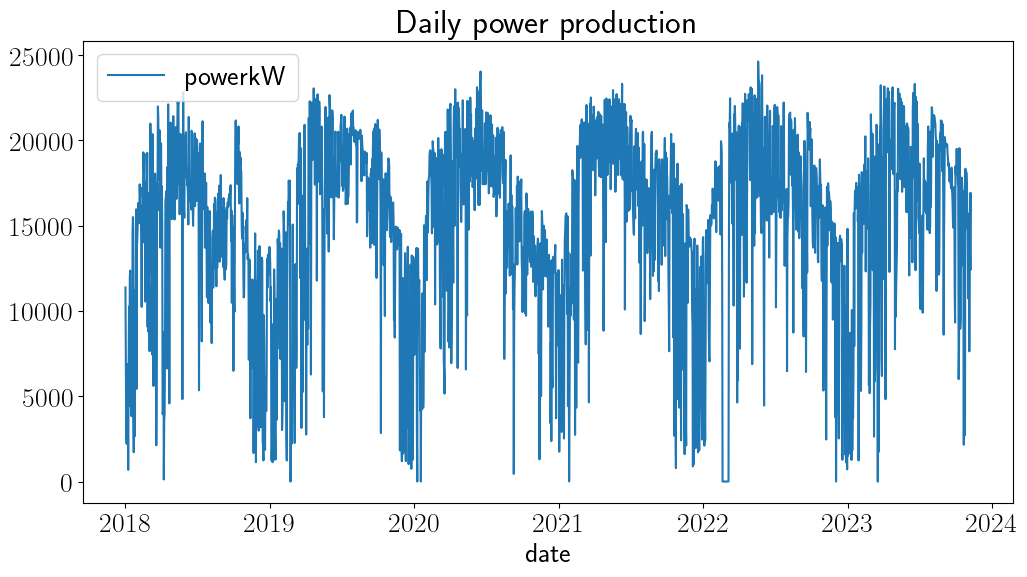

In [19]:
dailyAggPower.plot(title='Daily power production', figsize=(12, 6))

In [20]:
power = power[~power['date'].isin(datesOutliersLowPower) & ~power['date'].isin(datesOurliersHighPower)].copy()
powerClean = power[(power['datetime'].dt.year>=2019)].copy()   
# powerClean = power[(power['datetime'].dt.year>=2019) & (power['datetime'].dt.year<=2021)].copy()   
powerClean.reset_index(drop=True, inplace=True)
powerClean.drop(columns=['date'], inplace=True)

#### Scaling

In [21]:
powerScaled = powerClean.copy()
powerScaled['powerkW'] = powerScaled['powerkW'] / maxDataPowerkW * maxRefPowerkW

<Axes: title={'center': 'Power production'}, xlabel='datetime'>

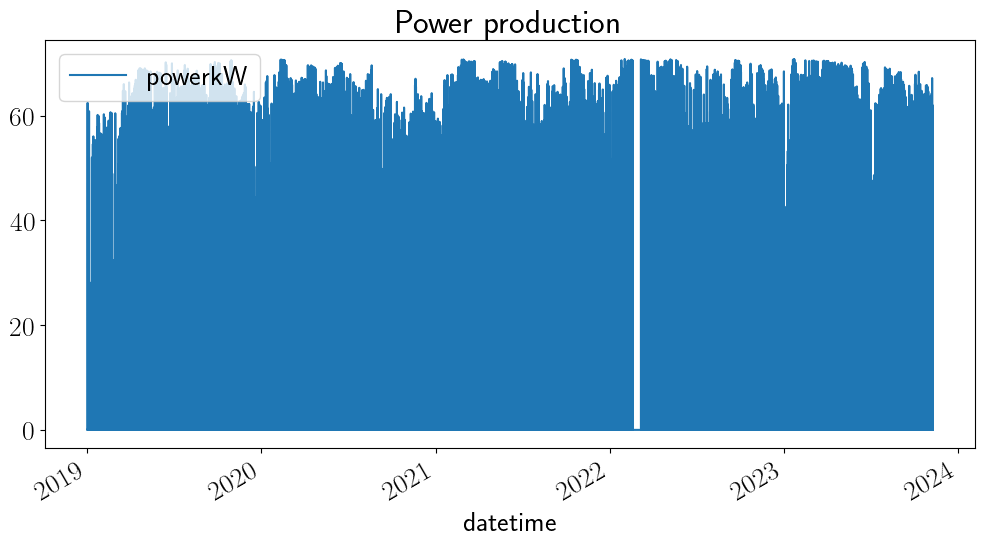

In [22]:
# powerClean.plot(x='datetime', y='powerkW', title='Power production', figsize=(20, 6))
powerScaled.plot(x='datetime', y='powerkW', title='Power production', figsize=(12, 6))

### Weather Forecasts

In [23]:
weather = pd.read_csv('Data/PVDAQ_2107_CA_US/open-meteo-39.00N122.13W110m_20182023.csv', skiprows=3)

In [24]:
weather.loc[:, 'datetime'] = pd.to_datetime(weather['time'], utc=True).dt.tz_convert('America/Los_Angeles')
weather.drop(columns=['time'], inplace=True)

In [25]:
weather.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)',
       'wind_speed_10m (km/h)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'global_tilted_irradiance (W/m²)',
       'datetime'],
      dtype='object')

In [26]:
weather.rename(columns={
    'temperature_2m (°C)': 'temp',
    'precipitation (mm)': 'precip',
    'wind_speed_10m (km/h)': 'wind',
    'direct_radiation (W/m²)': 'dirRad',
    'global_tilted_irradiance (W/m²)': 'gblRad',
    'diffuse_radiation (W/m²)': 'diffRad',
    'direct_normal_irradiance (W/m²)': 'dirNRad',
    }, inplace=True)

# weather.drop(columns='diffRad', inplace=True)
# weather = weather[['datetime', 'temp', 'dirRad', 'diffRad', 'gblRad']]
# weather = weather[['datetime', 'temp', 'dirRad', 'diffRad']]
weather = weather[['datetime', 'temp', 'dirRad', 'diffRad', 'wind']]
# weather = weather[['datetime', 'temp','dirRad', 'dirNRad', 'diffRad', 'wind']]

In [27]:
allData = pd.merge(powerScaled, weather, on='datetime', how='inner')

In [28]:
allData

,powerkW,datetime,temp,dirRad,diffRad,wind
0,0.0,2019-01-01 00:00:00-08:00,5.4,0.0,0.0,15.8
1,0.0,2019-01-01 00:15:00-08:00,5.2,0.0,0.0,15.6
2,0.0,2019-01-01 00:30:00-08:00,5.0,0.0,0.0,15.1
3,0.0,2019-01-01 00:45:00-08:00,4.8,0.0,0.0,15.2
4,0.0,2019-01-01 01:00:00-08:00,4.8,0.0,0.0,15.1
...,...,...,...,...,...,...
167778,0.0,2023-11-09 22:30:00-08:00,10.5,0.0,0.0,13.6
167779,0.0,2023-11-09 22:45:00-08:00,10.4,0.0,0.0,13.8
167780,0.0,2023-11-09 23:00:00-08:00,10.8,0.0,0.0,12.3
167781,0.0,2023-11-09 23:15:00-08:00,10.9,0.0,0.0,12.3


## Feature engineering

In [29]:
def calculate_solar_time(row, sunInfo):
    date = row['datetime'].date()
    solar_noon_time = sunInfo.loc[sunInfo['date'] == date, 'solarNoon'].values[0]
    solar_noon = solar_noon_time.hour * 3600 + solar_noon_time.minute * 60
    seconds_since_midnight = row['datetime'].hour * 3600 + row['datetime'].minute * 60 + row['datetime'].second
    solar_time = seconds_since_midnight - solar_noon
    return solar_time / 3600

def calculate_solar_zenith(row):
    zenith_angle = zenith(location.observer, row['datetime'])
    cos_zenith = np.cos(np.deg2rad(zenith_angle))
    return cos_zenith

allData['solarTime'] = allData.apply(lambda row: calculate_solar_time(row, sunInfo=sunInfo), axis=1)
allData['cosZenith'] = allData.apply(lambda row: calculate_solar_zenith(row), axis=1)
allData['monthOfYear'] = allData['datetime'].dt.month

allData_datetimes = allData.loc[:, ['datetime']].copy()
allData_datetimes['date'] = allData_datetimes['datetime'].dt.date
allData_daylightInfo = pd.merge(allData_datetimes, sunInfo, on='date', how='inner')
allData_daylightInfo['sunrise'] = allData_daylightInfo['sunrise'].dt.round('15min')
allData_daylightInfo['sunset'] = allData_daylightInfo['sunset'].dt.round('15min')
allData_daylightInfo['isDaylight'] = (allData_daylightInfo['datetime'] >= allData_daylightInfo['sunrise']) & (allData_daylightInfo['datetime'] < allData_daylightInfo['sunset'])
allData['isDaylight'] = allData_daylightInfo['isDaylight']

# n_hourly_lags1 = 4
# allData['powerkW4_sum'] = allData['powerkW'].rolling(window=n_hourly_lags1).sum()

allData['date'] = allData['datetime'].dt.date

daily_sum = allData.groupby('date')['powerkW'].sum().reset_index()
daily_sum.columns = ['date', 'sum']
lag_daily_sum = daily_sum.copy()
lag_daily_sum['isoDay_sum'] = daily_sum['sum'].shift(1)
lag_daily_sum.drop(columns=['sum'], inplace=True)

daily_std = allData.groupby('date')['powerkW'].std().reset_index()
daily_std.columns = ['date', 'std']
lag_daily_std = daily_std.copy()
lag_daily_std['isoDay_std'] = daily_std['std'].shift(1)
lag_daily_std.drop(columns=['std'], inplace=True)


allData = allData.merge(lag_daily_std, on='date', how='left')
allData = allData.merge(lag_daily_sum, on='date', how='left')
allData.drop(columns=['date'], inplace=True)

allData.dropna(inplace=True)

In [30]:
# pd.options.display.max_rows = 200
# allData.head(150)
allData.dtypes

powerkW                        float64
datetime       datetime64[ns, PST8PDT]
temp                           float64
dirRad                         float64
diffRad                        float64
wind                           float64
solarTime                      float64
cosZenith                      float64
monthOfYear                      int32
isDaylight                        bool
isoDay_std                     float64
isoDay_sum                     float64
dtype: object

In [31]:
allData['date'] = allData['datetime'].dt.date

In [32]:
nTestDays = 70

winter_dates = allData.loc[(allData['datetime'].dt.month >= 1) & (allData['datetime'].dt.year == yearTest) , 'datetime'].dt.date.unique()
start_winter = 0
test_days_winter = winter_dates[start_winter:start_winter + nTestDays] # nTestDays + 1
test_datetimes_winter = allData[allData['date'].isin(test_days_winter)]['datetime']
test_datetimes_winter = test_datetimes_winter[test_datetimes_winter.dt.date != pd.to_datetime('2021-03-14').date()].copy() # also remove the prices DST days

spring_dates = allData.loc[(allData['datetime'].dt.month >= 4) & (allData['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_spring = 0 
test_days_spring = spring_dates[start_spring:start_spring + nTestDays]
test_datetimes_spring = allData[allData['date'].isin(test_days_spring)]['datetime']

summer_dates = allData.loc[(allData['datetime'].dt.month >= 7) & (allData['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_summer = 0
test_days_summer = summer_dates[start_summer:start_summer + (nTestDays)]
test_datetimes_summer = allData[allData['date'].isin(test_days_summer)]['datetime']
test_datetimes_summer = test_datetimes_summer[(test_datetimes_summer.dt.date != (pd.to_datetime('2021-07-16').date())) & (test_datetimes_summer.dt.date != (pd.to_datetime('2021-07-17').date()))]

autumn_dates = allData.loc[(allData['datetime'].dt.month >= 10) & (allData['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_autumn = 0
test_days_autumn = autumn_dates[start_autumn:start_autumn + (nTestDays + 2)]
test_datetimes_autumn = allData[allData['date'].isin(test_days_autumn)]['datetime']
test_datetimes_autumn = test_datetimes_autumn[(test_datetimes_autumn.dt.date != pd.to_datetime('2021-11-7').date()) & (test_datetimes_autumn.dt.date != (pd.to_datetime('2021-10-27').date()))].copy() # also remove the prices DST days

test_datetimes = pd.concat([test_datetimes_winter, test_datetimes_spring, test_datetimes_summer, test_datetimes_autumn])

allData.drop(columns=['date'], inplace=True)

testPV = allData[allData['datetime'].isin(test_datetimes)]
# testPV = allData[allData['datetime'].dt.year == yearTest]
trainPV = allData[(allData['datetime'].dt.year != yearTest)]

X_train = trainPV.drop(columns=['datetime', 'powerkW'])
y_train = trainPV[['datetime', 'powerkW']]
X_test = testPV.drop(columns=['datetime', 'powerkW']) 
y_test = testPV[['datetime', 'powerkW']]

In [34]:
print(len(test_datetimes_winter), len(test_datetimes_spring), len(test_datetimes_summer), len(test_datetimes_autumn))
print(testPV[testPV['datetime'].isin(test_datetimes_winter)].shape[0], testPV[testPV['datetime'].isin(test_datetimes_spring)].shape[0], testPV[testPV['datetime'].isin(test_datetimes_summer)].shape[0], testPV[testPV['datetime'].isin(test_datetimes_autumn)].shape[0])

6720 6720 6720 6720
6720 6720 6720 6720


In [35]:
print(testPV.shape[0], len(test_datetimes))

26880 26880


In [36]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Train

In [37]:
# mapie_enbpi = pickle.load(open(f'Models/Ppv_MapieGBRv2_yearTest2021.pkl', 'rb'))

In [38]:
init_estimator = DummyRegressor(strategy='mean')
gbReg = GradientBoostingRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, validation_fraction=0.1, n_iter_no_change=15, loss='absolute_error', init=init_estimator, random_state=random_state)

In [39]:
cv_mapiets = BlockBootstrap(n_resamplings=15, length=96, overlapping=False, random_state=random_state)
mapie_enbpi = MapieTimeSeriesRegressor(gbReg, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train['powerkW']) 

/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/utils.py:565: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


In [41]:
modelName = 'Ppv_MapieGBRv2_yearTest' + str(yearTest)

In [42]:
pickle.dump(mapie_enbpi, open(f'Models/{modelName}.pkl', 'wb'))

## day-ahead preds

In [43]:
# alphas = [0.15, 0.25]
alphas = [0.1]

In [44]:
y_preds = np.zeros(len(X_test))
y_mapies = np.zeros((len(X_test), len(alphas), 2))

warnings.filterwarnings("ignore") 
for a in range(len(alphas)):
    pred, ci = mapie_enbpi.predict(X_test, alpha=alphas[a], ensemble=False, allow_infinite_bounds=False, optimize_beta=False)
    y_preds = np.clip(pred[:], a_min=0, a_max=None)
    y_mapies[:, a, :] = np.clip(ci[:, :, 0], a_min=0, a_max=None)

In [45]:
maxRangeAE = np.abs(y_preds-y_test['powerkW']).max() - np.abs(y_preds - y_test['powerkW']).min()
maxRangeAE

np.float64(51.425411208053944)

In [46]:
np.abs((y_preds-y_test['powerkW'])/maxRangeAE).mean()

np.float64(0.05715090471175807)

In [47]:
regression_coverage_score( y_test['powerkW'], y_mapies[:, 0, 0], y_mapies[:, 0, 1])

0.9110119047619047

In [48]:
X_test.shape

(26880, 10)

In [49]:
(y_preds == 0.0).sum()

np.int64(56)

In [50]:
len(y_preds)

26880

In [51]:
y_preds[X_test[X_test['isDaylight']==False].index] = 0
y_mapies[X_test[X_test['isDaylight']==False].index] = 0

In [52]:
y_test.head()

,datetime,powerkW
0,2021-01-01 00:00:00-08:00,0.0
1,2021-01-01 00:15:00-08:00,0.0
2,2021-01-01 00:30:00-08:00,0.0
3,2021-01-01 00:45:00-08:00,0.0
4,2021-01-01 01:00:00-08:00,0.0


In [53]:
noTitlePlots = True

In [54]:
def plot_daily_data_v2(filtered_y_test, filtered_y_pred, filtered_y_pi, season, start_days=0, length_days=4, showPlot=True):
    
    metricAE = np.abs(filtered_y_test['powerkW'] - filtered_y_pred)
    metricBias = filtered_y_pred - filtered_y_test['powerkW']
    coverage_enbpi_npfit = regression_coverage_score(
        filtered_y_test['powerkW'], filtered_y_pi[:, 0, 0], filtered_y_pi[:, 0, 1])
    width_enbpi_npfit = regression_mean_width_score(
        filtered_y_pi[:, 0, 0], filtered_y_pi[:, 0, 1])
    
    print(f"MAE: {np.round(metricAE.mean(), 2)}. nMAE: {np.round(metricAE.mean()/maxRangeAE, 4)}. Avg bias: {np.round(metricBias.mean(), 2)}")
    print(f'Coverage: {coverage_enbpi_npfit:.4f}. Width: {width_enbpi_npfit:.3f}')


    if start_days is not None:
        filtered_y_test = filtered_y_test.iloc[(start_days * 96):((start_days + length_days) * 96), :]
        filtered_y_pred = filtered_y_pred[(start_days * 96):((start_days + length_days) * 96)]
        filtered_y_pi = filtered_y_pi[(start_days * 96):((start_days + length_days) * 96)]
        filtered_AE = metricAE[(start_days * 96):((start_days + length_days) * 96)]

    if showPlot:
        fig, ax1 = plt.subplots(figsize=(8, 6))
        # fig, ax1 = plt.subplots(figsize=(12, 8))
        ax1.fill_between(filtered_y_test['datetime'], filtered_y_pi[:, 0, 0].flatten(), filtered_y_pi[:, 0, 1].flatten(), label=r'$\hat{P}_\mathrm{pv}^{\mathrm{p}5-\mathrm{p}95}$', color='papayawhip')
        if len(alphas) ==2:
            ax1.fill_between(filtered_y_test['datetime'], filtered_y_pi[:, 1, 0].flatten(), filtered_y_pi[:, 1, 1].flatten(), label=r'$\hat{P}_\mathrm{pv}^{\mathrm{p}25-\mathrm{p}75}$', color='papayawhip')
        ax1.plot(filtered_y_test['datetime'], filtered_y_test['powerkW'], label=r'$P_\mathrm{pv}$', color='tab:blue')
        ax1.plot(filtered_y_test['datetime'], filtered_y_pred, label=r'$\hat{P}_\mathrm{pv}$', color='orange')
        ax1.bar(filtered_y_test['datetime'], filtered_AE, width=0.01, color='lightpink', label=r'$|P_\mathrm{pv} - \hat{P}_\mathrm{pv}|$')

        ax1.set_xlabel(r'$\mathrm{Date}$')
        ax1.set_ylabel(r'$\mathrm{Power \, [kW]}$')
        # ax1.legend(loc='upper right', ncol=5)
        ax1.legend(loc='upper center', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, fontsize=22)
        ax1.set_ylim(0, maxRefPowerkW + 15)
        ax1.set_xlim(filtered_y_test['datetime'].min(), filtered_y_test['datetime'].max())
        # ax1.set_xticks(filtered_y_test['datetime'][::96*2]) #, rotation=45)  # Show every 96th datetime label
        # ax1.set_xticks(filtered_y_test['datetime'][96:-1:96*2]) #, rotation=45)  # Show every 96th datetime label
        ax1.set_xticks(filtered_y_test['datetime'][96:-1:96*1]) #, rotation=45)  # Show every 96th datetime label
        ax1.grid()
        if not noTitlePlots:
            plt.title(rf'$\mathrm{{{season}-24h\,Ahead\,Prediction\,at\,H0\,}}\mathrm{{(15min\,res.)}}$')
        plt.tight_layout()
        plt.show()
        # fig.savefig(f'Figures/{modelName}_{season}_24Hahead.svg', format='svg', dpi=300, bbox_inches='tight')
        # fig.savefig(f'Figures/{modelName}_{season}_24Hahead.eps', format='eps', dpi=300, bbox_inches='tight')


    return metricAE, metricBias, coverage_enbpi_npfit

MAE: 3.31. nMAE: 0.0644. Avg bias: -0.48
Coverage: 0.8783. Width: 7.213


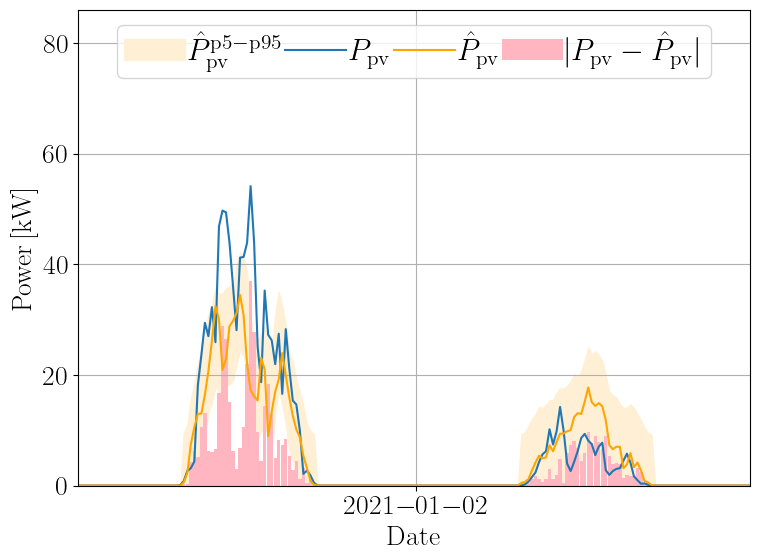

MAE: 2.53. nMAE: 0.0492. Avg bias: -0.33
Coverage: 0.9457. Width: 9.442


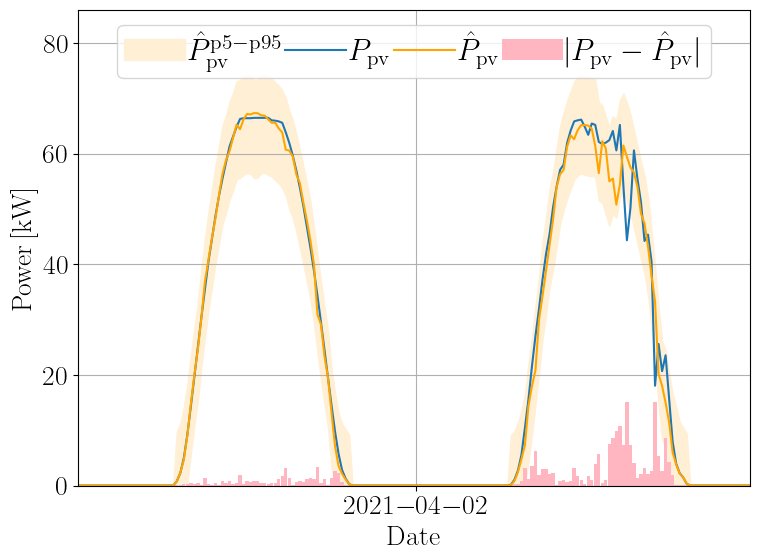

MAE: 2.75. nMAE: 0.0535. Avg bias: -0.01
Coverage: 0.9384. Width: 9.328


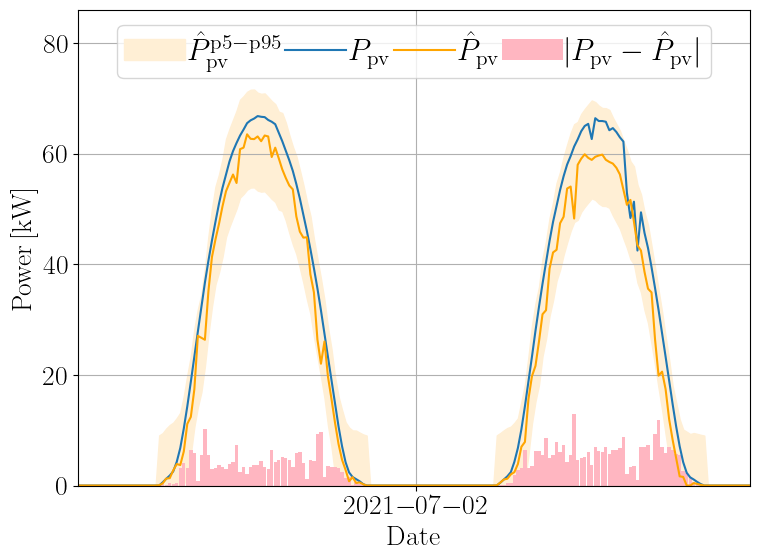

MAE: 3.17. nMAE: 0.0616. Avg bias: -0.65
Coverage: 0.8738. Width: 7.176


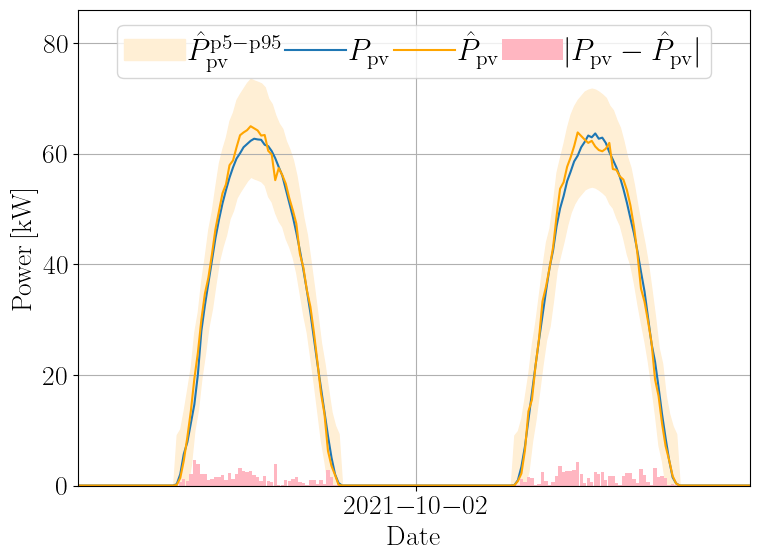

In [55]:
filtered_y_test_summer = y_test[y_test['datetime'].isin(test_datetimes_summer)]
filtered_y_test_summer_idx = y_test[y_test['datetime'].isin(test_datetimes_summer)].index
filtered_y_preds_summer = y_preds[filtered_y_test_summer_idx]
filtered_y_pis_summer = y_mapies[filtered_y_test_summer_idx]

filtered_y_test_winter = y_test[y_test['datetime'].isin(test_datetimes_winter)]
filtered_y_test_winter_idx = y_test[y_test['datetime'].isin(test_datetimes_winter)].index
filtered_y_preds_winter = y_preds[filtered_y_test_winter_idx]
filtered_y_pis_winter = y_mapies[filtered_y_test_winter_idx]

filtered_y_test_spring = y_test[y_test['datetime'].isin(test_datetimes_spring)]
filtered_y_test_spring_idx = y_test[y_test['datetime'].isin(test_datetimes_spring)].index
filtered_y_preds_spring = y_preds[filtered_y_test_spring_idx]
filtered_y_pis_spring = y_mapies[filtered_y_test_spring_idx]

filtered_y_test_autumn = y_test[y_test['datetime'].isin(test_datetimes_autumn)]
filtered_y_test_autumn_idx = y_test[y_test['datetime'].isin(test_datetimes_autumn)].index
filtered_y_preds_autumn = y_preds[filtered_y_test_autumn_idx]
filtered_y_pis_autumn = y_mapies[filtered_y_test_autumn_idx]

plot_n_days = 2
wntError, wntBias, wntWidth = plot_daily_data_v2(filtered_y_test_winter, filtered_y_preds_winter, filtered_y_pis_winter, 'Winter', length_days=plot_n_days, showPlot=True)
sprError, sprBias, sprWidth = plot_daily_data_v2(filtered_y_test_spring, filtered_y_preds_spring, filtered_y_pis_spring, 'Spring', length_days=plot_n_days, showPlot=True)
smrError, smrBias, smrWidth = plot_daily_data_v2(filtered_y_test_summer, filtered_y_preds_summer, filtered_y_pis_summer, 'Summer', length_days=plot_n_days, showPlot=True)
atmError, atmBias, atmWidth = plot_daily_data_v2(filtered_y_test_autumn, filtered_y_preds_autumn, filtered_y_pis_autumn, 'Autumn', length_days=plot_n_days, showPlot=True)

### Comparison Table

In [56]:
mean_errors = np.array([wntError.mean()/maxRangeAE, sprError.mean()/maxRangeAE, smrError.mean()/maxRangeAE, atmError.mean()/maxRangeAE])
mean_bias = np.array([wntBias.mean(), sprBias.mean(), smrBias.mean(), atmBias.mean()])
mean_width = np.array([wntWidth, sprWidth, smrWidth, atmWidth])
median_errors = np.array([wntError.median(), sprError.median(), smrError.median(), atmError.median()])

rounded_mean_errors = [round(err, 4) for err in mean_errors]
rounded_mean_bias = [round(b, 2) for b in mean_bias]
rounded_mean_width = [round(b, 4) for b in mean_width]
rounded_median_errors = [round(err, 2) for err in median_errors]

pd.DataFrame({'Season': ['Winter', 'Spring', 'Summer', 'Autumn'], 'MAE': rounded_mean_errors, 'Bias': rounded_mean_bias,
              'Width': rounded_mean_width})

,Season,MAE,Bias,Width
0,Winter,0.0644,-0.48,0.8783
1,Spring,0.0492,-0.33,0.9457
2,Summer,0.0535,-0.01,0.9384
3,Autumn,0.0616,-0.65,0.8738


## Energy hub

### save eval info

In [ ]:
# saveEval = testPV.reset_index(drop=True).copy()

In [57]:
def season_datetimes(season, yearTest):
    
    if season == 'winter':
        start_date = pd.Timestamp(year=yearTest, month=1, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=3, day=31, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'spring':
        start_date = pd.Timestamp(year=yearTest, month=4, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=6, day=30, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'summer':
        start_date = pd.Timestamp(year=yearTest, month=7, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=9, day=30, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'autumn':
        start_date = pd.Timestamp(year=yearTest, month=10, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=12, day=31, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    
    datetimes_season = pd.date_range(start=start_date, end=end_date, freq='15min')

    if season == 'winter':
        return datetimes_season[datetimes_season.date != (pd.to_datetime('2021-03-14').date())]
    if season == 'summer':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime('2021-07-16').date())) & (datetimes_season.date != (pd.to_datetime('2021-07-17').date()))]
    if season == 'autumn':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime('2021-11-07').date())) & (datetimes_season.date != (pd.to_datetime('2021-10-27').date()))]
    else:
        return datetimes_season


In [58]:
def filter_eval_datetime(n_days_eval_per_season, n_days_rolling_feature):
    eval_datetimes = pd.DatetimeIndex([])
    for s in ['winter', 'spring', 'summer', 'autumn']:
        s_dt = season_datetimes(s, yearTest)
        eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season)])
    return eval_datetimes

In [59]:
save_datetimes = filter_eval_datetime(n_days_eval_per_season=88, n_days_rolling_feature=0)

In [60]:
saveEval = testPV.loc[testPV['datetime'].isin(save_datetimes), :].reset_index(drop=True)

In [61]:
saveEval.reset_index(drop=True, inplace=True)

In [62]:
saveEval

,powerkW,datetime,temp,dirRad,diffRad,wind,solarTime,cosZenith,monthOfYear,isDaylight,isoDay_std,isoDay_sum
0,0.0,2021-01-01 00:00:00-08:00,9.4,0.0,0.0,17.4,-12.200000,-0.960131,1,False,21.435976,1240.255999
1,0.0,2021-01-01 00:15:00-08:00,9.4,0.0,0.0,17.1,-11.950000,-0.961074,1,False,21.435976,1240.255999
2,0.0,2021-01-01 00:30:00-08:00,9.4,0.0,0.0,17.4,-11.700000,-0.958955,1,False,21.435976,1240.255999
3,0.0,2021-01-01 00:45:00-08:00,9.3,0.0,0.0,17.4,-11.450000,-0.953782,1,False,21.435976,1240.255999
4,0.0,2021-01-01 01:00:00-08:00,9.2,0.0,0.0,17.6,-11.200000,-0.945578,1,False,21.435976,1240.255999
...,...,...,...,...,...,...,...,...,...,...,...,...
26875,0.0,2021-12-11 22:45:00-08:00,9.1,0.0,0.0,13.3,10.733333,-0.921478,12,False,23.879764,1424.127999
26876,0.0,2021-12-11 23:00:00-08:00,9.0,0.0,0.0,13.7,10.983333,-0.935501,12,False,23.879764,1424.127999
26877,0.0,2021-12-11 23:15:00-08:00,8.8,0.0,0.0,13.8,11.233333,-0.946577,12,False,23.879764,1424.127999
26878,0.0,2021-12-11 23:30:00-08:00,8.6,0.0,0.0,13.5,11.483333,-0.954657,12,False,23.879764,1424.127999


In [63]:
fileName = 'AllTest_pv_2021_v0'

In [64]:
saveEval.to_csv(f'EnergyHubEval/{fileName}.csv', index=False)